# Image search with autoencoders

Autoencoders are an architecture that have a variety of applications from [denoising data](http://www.jmlr.org/papers/volume11/vincent10a/vincent10a.pdf) to [generative models](http://kvfrans.com/variational-autoencoders-explained/).

In this post we will look at how to search for similar images given a query image with autoencoders and implement one with [keras](http://keras.io). While we will focus on image searches autoencoders have been shown to work well in other settings as well, for example text-based problems such as retrieving for relevant news articles (see the resource section at the end of this post).

# Autoencoders

## The gist

Autoencoders are simply neural networks that learn the mapping $f:X\mapsto X$. Does that sound too easy? Are you wondering why we would want to predict the input we are already given?

The key idea that makes this mapping useful is that a "bottleneck" is placed in the middle of the network which implicitly forces the network to learn a compressed representation of the input data. It is important to note that this is the only output from the network that we are actually interested in.

More specifically we think of an autoencoder as two pieces. First there is the _encoder_, the first half of the network that maps $X\in \mathbb{R}^{n}$ to some vector in $\mathbb{R}^{d}$ where $d<n$. Second we have the _decoder_ which maps that vector back to the orignal feature space $\mathbb{R}^{n}$. The vector output by the encoder is known as the _latent representation_ of the data and is what we will use to search for images by. Again, it is important to understand that at the end of the day all we really care about is the output of the bottleneck.

In keras implementing an autoencoder is (almost) as simple as

```python
import keras
model = keras.models.Sequential([
    Dense(1000),
    Dense(500),
    Dense(250),
    Dense(64),
    Dense(250),
    Dense(500),
    Dense(1000)
])
```

Note that the output of the middle layer `Dense(250)` is the latent representation, or code.

## The intuition

One nice thing about autoencoders is that the idea described above is very intuitive. Suppose our data $X$ lives in $\mathbb{R}^{n}$ and one of the hidden layers of $f$ outputs a vector of dimmension $d<n$. Then, it follows that if $f$ reconstructs $X$ well after reducing the input in dimmensionality then that $d$-dimmensional vector must contain a lot of information about the input itself in order to reproduce it.

# Autoencoders for searching

So how do autoencoders apply to searching?

Let's consider the use case where we have a set of images $X$, and for a given image, $q$, we would like to retrieve all images in $X$ that are "similar" to $q$.

One such way to do this with an autoencoder is to keep a list of key-value pairs of each image $x\in X$ and its encoded representation $\hat{x}$ (the output of the latent layer when we predict on $x$). Recall these codes are simply vectors, so we can compute similarity scores of $\hat{q}$ with each $\hat{x}$, returning the images which scored highest.

Now, this method is already more efficient than simply computing the similarity scores over the raw values in $X$ - in the sense that the encoded representations are much smaller in dimmension. Nevertheless, both approaches run in linear time, that is the more images we have in our database, the longer the search will take and the less benefit we see in performance from computing the similarity scores on smaller vectors.

It turns out we can still use the codes to perform a faster search in constant time, we just need to build the autoencoder with one slight modification. Instead of mapping the input to vectors of dimmension $d$, we define the encoder as $\phi:\mathbb{R}^{n}\mapsto\{0,1\}^{d}$ ($d$-bit binary codes). Once again we keep a list of KVPs, but this time the key is a $d$-bit integer representing the $d$-bit code from the encoder.

To complete the search over these KVPs we implement something called [semantic hashing](http://www.cs.utoronto.ca/~rsalakhu/papers/semantic_final.pdf). The idea is simple. For our query image $q$ we now return all images $x\in X$ such that the hamming distince (number of bits that differ) of $\phi(q)$ and $\phi(x)$ is less than some predetermined threshold $t$.

# A few remarks on building and training the autoencoder

## Learning binary codes

You may be asking how does one constrain the neural network to learn binary codes. It turns out this is actually rather simple. Several techniques are discussed in [semantic hashing](http://www.cs.utoronto.ca/~rsalakhu/papers/semantic_final.pdf), however the simplest method, described [here](http://www.cs.toronto.edu/~fritz/absps/esann-deep-final.pdf), is to round the outputs of the encoder up to 1 or down to 0 (these will already be values between 0 and 1 since we use a softmax for the activation of this layer) and then compute the gradient update as if the rounding never occurred.

We can do this in keras with a custom layer using `keras.backend.round()` and `keras.backend.stop_gradient()` as follows

```python
import keras
from keras.layers import Lambda
def binarize(x):
    return x + K.stop_gradient(K.round(x) - x)
Binarize = Lambda(binarize, output_shape=lambda x: x, name='encoding')
```

## Choosing the latent dimmension and threshold

When choosing the size of the latent dimmension it is useful to consider the following heuristic. As a specific example we'll consider searching over the MNIST digits since that's the data we'll work with below. Specifically we will use the MNIST training set provided by `keras.datasets.mnist` which contains 60,000 images.

In the papers referenced at the end of this post the author's found good results when each code mapped to approximately 0.4 items (images in our case). Following this pattern, we will chose $d$ such that $60000/2^{d}\approx 0.4$, that is $d=17$. The key idea is for $d$ to be large enough for the model to train well, yet small enough that we will actually find images with codes within a given hamming distance of our query code.

Choosing the threshold $t$ will depend on the use case. Just keep in mind that the number of images, $n$, you should expect to retrieve for a given query is

$$n\approx\frac{|X|}{2^{d}}\sum_{i=0}^{t}{\binom{d}{i}}$$

In our case, choosing $t=3$ this is approximately $0.46*834\approx 384$ images.

(If you're paying attention you will have noticed that we assume the model will distribute the images uniformly accross the $d$-bit space. If the autoencoder reconstructs the input images well then this is reasonable to assume since the autoencoder would have to "spread out" the images accross the codes since the final output of the autoencoder is determined by the codes. At least, this holdes for our case where we know that the digits are uniformly distributed in the training set.)

## Overfitting on the data

Note that in some cases there may not be a need for the autoencoder to generalize to new data if the entire database that will be searched over is available at train time. Thus overfitting to the training data would only improve the search results.

# Implementing the autoencoder

Now we'll take a look at implementing an autoencoder in keras. I won't share the full source code, which can be found [here](https://github.com/dantegates/image-search), but I will highlight the main points and look at the results.

First we'll import the `AutoEncoder` class that I've defined (which is a sublcass of the `keras.models.Model` and look at its class signature.

In [1]:
from autoencoders import AutoEncoder
help(AutoEncoder.__init__)

/home/dante/venvs/default/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Help on function __init__ in module autoencoders:

__init__(self, input_dim, latent_dim, intermediate_dims, output_activation)
    Initialize an ``AutoEncoder``.
    
    Args:
        input_dim (int): Dimension of the input.
        latent_dim (int): Dimension of the "latent representation" or code.
        intermediate_dims (list): List of `int`s representing the
            dimmension of the hidden layers up to, but not including, the
            latent layer. See the example below.
        output_activation (str or object): The activation used on the final
            output of the autoencoder. This gets passed on to the underlying
            `keras` implementation.
    
    Example
    -------
    The instance
    
    >>> autoencoder = AutoEncoder(784, 32, [256, 128])
    
    will have the following architecture ::
        
        |--------- 784 ---------|       INPUT
    
           |------ 256 ------|
    
              |--- 128 ---|
    
                |-  32 -|           

The implementation uses `keras` functional API by looping over the intermediate dimmensions and "stacking" `keras.layers.Dense` layers on top of each other. You can read more about the functional API in the [docs](https://keras.io/getting-started/functional-api-guide/). My implementation is similar to the keras [tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) building autoencoders with one improvement. Rather than keeping track of the encoder and decoder as separate objects, I simply name the encoder layer, i.e.

```python
Binarize = Lambda(binarize, output_shape=lambda x: x, name=ENCODING_LAYER_NAME)
```

Then we can implement a property that grabs this layer by name and instantiates another `keras.models.Model` when we want to use the encoder after training

```python
class AutoEncoder(keras.models.Model):
    ...
    @property
    def bit_encoder(self):
        encoding = self.get_layer(ENCODING_LAYER_NAME).get_output_at(-1)
        return keras.models.Model(inputs=self.input, outputs=encoding)
```

Now that we've gone over the implementation, let's train the model and look at the results.

In [2]:
from utils import *
X_train, _ = fetch_data()
X_train.shape

(60000, 784)

In [3]:
autoencoder = AutoEncoder(
    input_dim=X_train.shape[-1],
    latent_dim=17,
    intermediate_dims=[1000, 700, 300,  150, 75],
    output_activation='sigmoid')

In [4]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              785000    
_________________________________________________________________
dense_2 (Dense)              (None, 700)               700700    
_________________________________________________________________
dense_3 (Dense)              (None, 300)               210300    
_________________________________________________________________
dense_4 (Dense)              (None, 150)               45150     
_________________________________________________________________
dense_5 (Dense)              (None, 75)                11325     
_________________________________________________________________
dense_6 (Dense)              (None, 17)                1292      
__________

In [5]:
autoencoder.compile(loss='binary_crossentropy', optimizer='adadelta')

In [6]:
hist = autoencoder.fit(X_train, X_train,
                       epochs=300,
                       batch_size=256,
                       verbose=0,  # set verbosity to 0 so this post doesn't get cluttered
                                   # we'll look at the loss from the keras history
                       shuffle=True)

In [7]:
# just show the loss every 25 epochs
hist.history['loss'][::25]

[0.30306147510210674,
 0.1807299651781718,
 0.16143394440015157,
 0.15484075319767,
 0.15067801921367646,
 0.1484384158372879,
 0.14725831627051036,
 0.14619022978941598,
 0.14550789261658986,
 0.14499121417204539,
 0.14470724340279897,
 0.1443879818201065]

## Train results
Now that we have trained the autoencoder, lets randomly sample images from the test set and see how well it can reconstruct them.

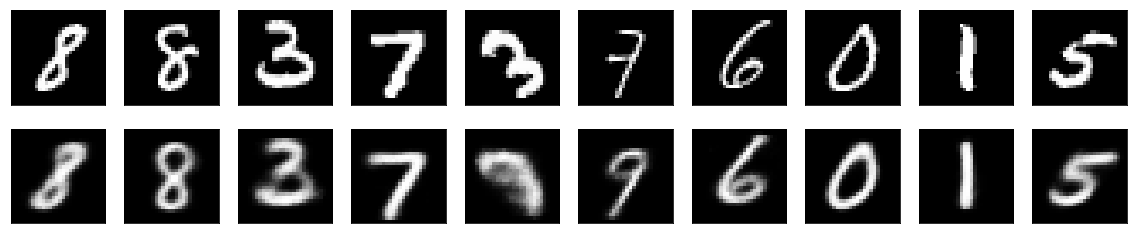

In [8]:
# randomly sample 10 images and look at output
test_sample = choices(X_train, k=10)
reconstructions = autoencoder.predict(test_sample)
show_side_by_side(test_sample, reconstructions)

## Linear search
The model looks like it has trained well. Now we can pull out the encoder from the model and take a look at how it performs using a simple linear search using cosine similarity.

In [9]:
encoder = autoencoder.bit_encoder

In [10]:
# define key-value pairs of encoding, image for search
kvps = [(code, image) for code, image in zip(encoder.predict(X_train), X_train)]

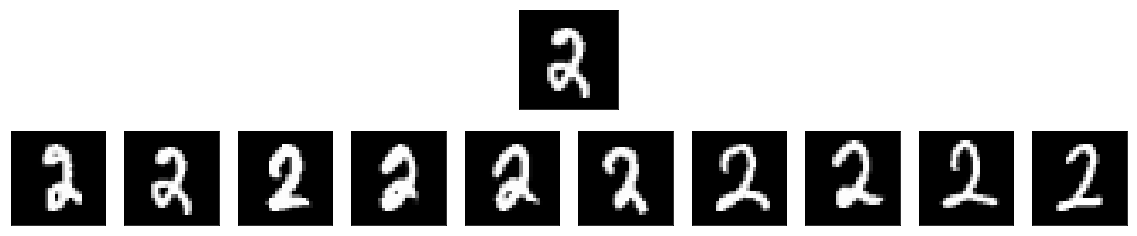

CPU times: user 1.31 s, sys: 13.9 ms, total: 1.33 s
Wall time: 1.32 s


In [11]:
%%time
import random
# pick on image from test set
QUERY_IMG = random.choice(X_train).reshape(1, 784)

# retrieve similar images
query_code = encoder.predict(QUERY_IMG)
sims = [(cosine_sim(query_code, stored_code), image) for stored_code, image in kvps]
# get top 10 images
sorted_sims = sorted(sims, reverse=True, key=lambda x: x[0])
top_matches = [img for _, img in sorted_sims[:10]]

show_side_by_side(QUERY_IMG, top_matches)

In [12]:
# the codes are binary aren't they?
query_code

array([[1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0.,
        1.]], dtype=float32)

# Semantic hashing

Lastly, we'll take a look at search results given the same query image, but using the "semantic hash table." (implemented in [semantic_hashing.py](https://github.com/dantegates/image-search/blob/master/semantic_hashing.py))

In [13]:
from semantic_hashing import DB
encoder = autoencoder.integer_encoder  # keras model that converts binary code to integers

In [14]:
%%time
db = DB(encoder, X_train)

CPU times: user 27.2 s, sys: 823 ms, total: 28 s
Wall time: 7.51 s


In [15]:
# look at some values that make use feel good about our choice of $d$
db.describe()

median density: 2.0
mean density: 4.056795131845842
min density: 1
max density: 109


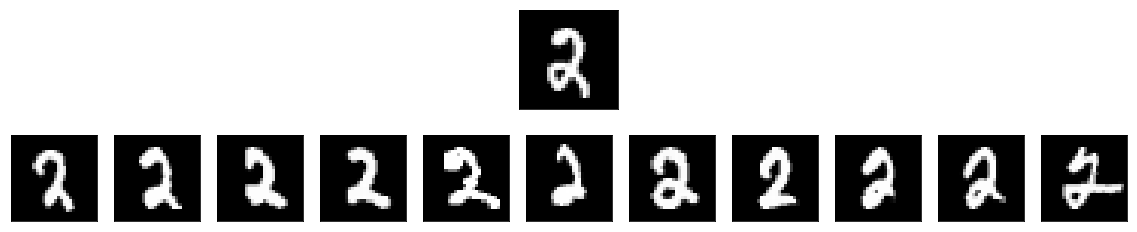

CPU times: user 404 ms, sys: 8.04 ms, total: 412 ms
Wall time: 412 ms


In [16]:
%%time
res = db.search(QUERY_IMG, threshold=1)
show_side_by_side(QUERY_IMG, res)

Note that even on this relatively small data set we already observe much faster lookups without any noticable impact to the search performance.

## Resources

For further information see the papers which introduced autoencoders and guided this post are

- [Semantic Hashing](http://www.cs.utoronto.ca/~rsalakhu/papers/semantic_final.pdf)
- [Using Very Deep Autoencoders for Content-Based Image Retrieval](http://www.cs.toronto.edu/~fritz/absps/esann-deep-final.pdf).